# Отключаем сообщения

In [2]:
from transformers import logging
logging.set_verbosity_error() # set_verbosity_warning()

import warnings
warnings.filterwarnings("ignore")

# Чанки

In [6]:
from langchain_community.document_loaders import TextLoader, Docx2txtLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chat_models.gigachat import GigaChat

def file_to_chunks(file_name, sep, chunk_size, chunk_overlap):
    file_ext = file_name.split('.')[-1]
    file_path = f'{TEST_FOLDER_PATH}/{file_name}'

    # Загружаем содержимое файла
    if file_ext == 'txt':
        loader = TextLoader(file_path, encoding='utf-8')
    elif file_ext == 'docx':
        loader = Docx2txtLoader(file_path)
    elif file_ext == 'pdf':
        loader = PyPDFLoader(file_path)
    else:
        return
    file = loader.load()
    content = file[0].page_content

    # Разбиваем текст на чанки
    text_splitter = RecursiveCharacterTextSplitter(
        separators = sep,
        chunk_size = chunk_size,
        chunk_overlap = chunk_overlap,
        length_function = len,
        is_separator_regex = False,
        add_start_index = False
    )
    chunks = text_splitter.split_text(content)

    return chunks

# Bi-encoder

In [36]:
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import Pooling, Transformer

# Подгружаем bi-encoder
def get_bi_encoder(bi_encoder_name):
    raw_model = Transformer(model_name_or_path=f'{bi_encoder_name}')

    # Вытаскиваем размер векторов
    bi_encoder_dim = raw_model.get_word_embedding_dimension()

    pooling_model = Pooling(
        bi_encoder_dim,
        pooling_mode_cls_token = False,
        pooling_mode_mean_tokens = True
    )
    bi_encoder = SentenceTransformer(
        modules = [raw_model, pooling_model],
        device = 'cuda' # помещаем его на GPU
    )

    return bi_encoder, bi_encoder_dim

# Формируем из строки вектор
def str_to_vec(bi_encoder, text):
    embeddings = bi_encoder.encode(
        text,
        convert_to_tensor = False,
        show_progress_bar = False
    )
    return embeddings

# Qdrant

In [38]:
import uuid

from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct


# Создаем подключение к векторной БД
qdrant_client = QdrantClient(':memory:')

# Помещаем чанки и доп. информаицю в векторую БД
def save_chunks(bi_encoder, chunks, file_name):
    # Конвертируем чанки в векитора
    chunk_embeddings = str_to_vec(bi_encoder, chunks)

    # Содаем объект(ы) для БД
    points = []
    for i in range(len(chunk_embeddings)):
        point = PointStruct(
            id=str(uuid.uuid4()), # генерируем GUID
            vector = chunk_embeddings[i],
            payload={'file': file_name, 'chunk': chunks[i]}
        )
        points.append(point)

    # Сохраняем вектора в БД
    operation_info = qdrant_client.upsert(
        collection_name = COLL_NAME,
        wait = True,
        points = points
    )

    return operation_info

def files_to_vecdb(files, bi_encoder, vec_size, sep, chunk_size, chunk_overlap):
    # Удаляем и заново создаем коллекцию
    qdrant_client.delete_collection(collection_name=COLL_NAME)
    qdrant_client.create_collection(
        collection_name = COLL_NAME,
        vectors_config = VectorParams(size=vec_size, distance=Distance.COSINE),
    )

    # Каждый файл по одному...
    for file_name in files:
        # делим на чанки ...
        chunks = file_to_chunks(file_name, sep, chunk_size, chunk_overlap)
        # помещаем чанки в векторную БД
        operation_status = save_chunks(bi_encoder, chunks, file_name)

# Поиск векторов

In [14]:
def vec_search(bi_encoder, query, n_top_cos):
    # Кодируем запрос в вектор
    query_emb = str_to_vec(bi_encoder, query)

    # Поиск в БД
    search_result = qdrant_client.search(
        collection_name = COLL_NAME,
        query_vector = query_emb,
        limit = n_top_cos,
        with_vectors = False
    )

    top_chunks = [x.payload['chunk'] for x in search_result]
    top_files = list(set([x.payload['file'] for x in search_result]))

    return top_chunks, top_files

# LLM

In [17]:
llm = GigaChat(credentials='OGMwNTUyMzktMjM0Ny00MDIxLThiZWQtNDlkY2E3ODkxOTk5OmIyNTI4MDQ3LTEyNzQtNGIzMy1iZGNkLTNkNzg4MDEyZWY4Mg==',
                verify_ssl_certs=False)


In [87]:
from langchain_core.messages import HumanMessage, SystemMessage

def get_llm_answer(query, chunks_join, max_new_tokens, temperature, top_p, top_k):
    user_prompt = '''Ты структурированно отвечаешь на вопрос на основе контекста.
    Предлагай пользователю задать дополнительные похожие вопросы. Предлагай контекстную и справочную информацию,
    основываясь на метаданных каждого документа из контекста.
    Если ответа на вопрос нет в контексте, сообщи об этом.
    Контекст: {chunks_join}
    Вопрос: {query}
    Ответ:'''.format(chunks_join=chunks_join, query=query)

    SYSTEM_PROMPT = "Ты — Гигачат, русскоязычный автоматический ассистент. Ты разговариваешь с людьми и помогаешь им."

    # Объединяем системный и пользовательский промпт в корректном формате
    messages = [[SystemMessage(content=SYSTEM_PROMPT), HumanMessage(content=user_prompt)]]

    # Используем модель llm для получения ответа
    response = llm.generate(
        messages=messages,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k
    )

    return response.generations[0][0].message.content

# Оценка

In [23]:
import re
import json
from rouge import Rouge
from pymorphy3 import MorphAnalyzer

f = open('/content/drive/MyDrive/documents/RAG/research/stopwords-ru.json', encoding='utf-8')
stop_words = json.load(f)
#print(stop_words)

morph = MorphAnalyzer()
patterns = "[«»°!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(string):
    clear = re.sub(patterns, ' ', string)
    tokens = []
    for token in clear.split():
        if token:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            if token not in stop_words:
                tokens.append(token)
    tokens = ' '.join(tokens)
    return tokens

def get_llm_score(answer, answer_true):
    answer = lemmatize(answer)
    answer_true = lemmatize(answer_true)
    if len(answer) == 0:
        answer = '-'

    rouge = Rouge()
    scores = rouge.get_scores(answer, answer_true)[0]
    rouge_1 = round(scores['rouge-1']['r']*100, 2)

    return rouge_1

In [24]:
def get_context_score(chunks_join, context):
    rouge = Rouge()
    scores = rouge.get_scores(chunks_join, context)[0]
    score = round(scores['rouge-l']['r'] * 100)
    return score

# Выполнение теста

In [90]:
def run_one_test(df, encoder_name, sep, chunk_size, chunk_overlap, n_top_cos, max_new_tokens, temperature, top_p, top_k):
    bi_encoder, vec_size = get_bi_encoder(encoder_name)

    files = df['Файл'].unique()
    files_to_vecdb(files, bi_encoder, vec_size, sep, chunk_size, chunk_overlap)

    result = []
    for i, row in df.iterrows():
        query = row['Вопрос']
        answer_true = row['Правильный ответ']
        file_name = row['Файл']
        context = row['Контекст']

        # Проверка типов
        if not isinstance(query, str):
            print(f"Неправильный тип для 'Вопрос' в строке {i}: {query}")
            continue
        if not isinstance(answer_true, str):
            print(f"Неправильный тип для 'Правильный ответ' в строке {i}: {answer_true}")
            continue
        if not isinstance(file_name, str):
            print(f"Неправильный тип для 'Файл' в строке {i}: {file_name}")
            continue
        if not isinstance(context, str):
            print(f"Неправильный тип для 'Контекст' в строке {i}: {context}")
            continue

        top_chunks, top_files = vec_search(bi_encoder, query, n_top_cos)

        # Проверка типов для top_chunks
        if not all(isinstance(chunk, str) for chunk in top_chunks):
            print(f"Некорректные данные в top_chunks для запроса '{query}': {top_chunks}")
            continue

        row['top_files'] = top_files
        row['top_chunks'] = top_chunks
        top_chunks_join = '\n'.join(top_chunks)  # объединяем чанки

        answer = get_llm_answer(query, top_chunks_join, max_new_tokens, temperature, top_p, top_k)
        row['Ответ'] = answer
        #print(answer)
        row['file_score'] = int(file_name in top_files)
        row['context_score'] = get_context_score(top_chunks_join, context)
        row['llm_score'] = get_llm_score(answer, answer_true)

        result.append(row)

    result = pd.DataFrame(result)
    result = result.sort_values(by=['llm_score','context_score','file_score'], ascending=False)
    result = result.reset_index(drop=True)

    score = result['llm_score'].mean()

    return result, score


# Запуск Optuna'ы

In [28]:
import optuna

def objective(trial):
    global best_score, best_result

    encoder_name = trial.suggest_categorical('encoder_name', ['cointegrated/rubert-tiny2',
                                                              'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'])
    sep = trial.suggest_categorical('sep', ['.',' ','\n'])

    chunk_size = trial.suggest_int('chunk_size', 600, 2000)
    chunk_overlap = trial.suggest_int('chunk_overlap', 100, 600)
    n_top_cos = trial.suggest_int('n_top_cos', 1, 8)

    max_new_tokens = trial.suggest_int('max_new_tokens', 100, 1000)
    temperature = trial.suggest_float('temperature', 0.01, 0.99)
    top_p = trial.suggest_float('top_p', 0.01, 0.99)
    top_k = trial.suggest_int('top_k', 10, 150)

    result, score = run_one_test(
        TEST_DF,
        encoder_name,
        sep, chunk_size, chunk_overlap, n_top_cos,
        max_new_tokens, temperature, top_p, top_k
    )

    if score > best_score:
        best_score = score
        best_score_tag = ' <--'
        best_result = result
    else:
        best_score_tag = ''

    print(f'{score:.2f}', best_score_tag)

    return score

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [91]:
import pandas as pd

COLL_NAME = 'optuna_my_test'
TEST_FILE_PATH = '/content/drive/MyDrive/documents/RAG/research/ru_rag_test_dataset.pkl'
TEST_FOLDER_PATH = '/content/drive/MyDrive/documents/RAG/research/files'

TEST_DF = pd.read_pickle(TEST_FILE_PATH)[::15]
print('Кол-во строк:', TEST_DF.shape[0])


best_score = 0
best_result = None

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500, timeout=60*60*24)

Кол-во строк: 62


44.51  <--


55.32  <--


47.80 


30.78 


43.58 


58.06  <--


36.50 


44.47 


45.56 


64.52  <--


51.22 


62.61 


66.82  <--


[W 2024-09-29 15:56:14,550] Trial 13 failed with parameters: {'encoder_name': 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2', 'sep': '.', 'chunk_size': 1029, 'chunk_overlap': 395, 'n_top_cos': 5, 'max_new_tokens': 640, 'temperature': 0.34038345242780205, 'top_p': 0.3891060559861204, 'top_k': 95} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-28-630db696cb3e>", line 19, in objective
    result, score = run_one_test(
  File "<ipython-input-90-82390a89dbad>", line 5, in run_one_test
    files_to_vecdb(files, bi_encoder, vec_size, sep, chunk_size, chunk_overlap)
  File "<ipython-input-38-460df63645d5>", line 47, in files_to_vecdb
    operation_status = save_chunks(bi_encoder, chunks, file_name)
  File "<ipython-input-38-460df63645d5>", line 13, in save_chunks
    chunk_embeddings 

KeyboardInterrupt: 

In [92]:
opuna_df = study.trials_dataframe()
opuna_df

,number,value,datetime_start,datetime_complete,duration,params_chunk_overlap,params_chunk_size,params_encoder_name,params_max_new_tokens,params_n_top_cos,params_sep,params_temperature,params_top_k,params_top_p,state
0,0,44.508548,2024-09-29 15:33:43.639050,2024-09-29 15:34:46.717970,0 days 00:01:03.078920,110,1653,cointegrated/rubert-tiny2,457,1,\n,0.648665,105,0.863927,COMPLETE
1,1,55.324839,2024-09-29 15:34:46.718298,2024-09-29 15:35:55.938448,0 days 00:01:09.220150,521,1593,cointegrated/rubert-tiny2,322,2,,0.562592,15,0.122662,COMPLETE
2,2,47.795806,2024-09-29 15:35:55.938873,2024-09-29 15:37:02.157081,0 days 00:01:06.218208,469,751,cointegrated/rubert-tiny2,357,6,\n,0.053181,136,0.575313,COMPLETE
3,3,30.775806,2024-09-29 15:37:02.157319,2024-09-29 15:38:09.290714,0 days 00:01:07.133395,134,1425,cointegrated/rubert-tiny2,507,6,,0.524387,32,0.104060,COMPLETE
4,4,43.579032,2024-09-29 15:38:09.290954,2024-09-29 15:39:31.353000,0 days 00:01:22.062046,566,706,cointegrated/rubert-tiny2,160,3,,0.569397,30,0.957928,COMPLETE
5,5,58.064516,2024-09-29 15:39:31.353421,2024-09-29 15:41:28.949359,0 days 00:01:57.595938,105,744,sentence-transformers/paraphrase-multilingual-...,342,3,,0.355345,16,0.905532,COMPLETE
6,6,36.497742,2024-09-29 15:41:28.949619,2024-09-29 15:42:44.628772,0 days 00:01:15.679153,571,669,cointegrated/rubert-tiny2,356,8,.,0.608458,70,0.868423,COMPLETE
7,7,44.472097,2024-09-29 15:42:44.629041,2024-09-29 15:44:39.669284,0 days 00:01:55.040243,299,1363,sentence-transformers/paraphrase-multilingual-...,804,1,.,0.648490,121,0.174780,COMPLETE
8,8,45.559032,2024-09-29 15:44:39.669593,2024-09-29 15:46:34.648044,0 days 00:01:54.978451,198,1683,sentence-transformers/paraphrase-multilingual-...,183,3,,0.149339,57,0.269527,COMPLETE
9,9,64.518387,2024-09-29 15:46:34.648310,2024-09-29 15:49:41.909430,0 days 00:03:07.261120,538,722,sentence-transformers/paraphrase-multilingual-...,397,3,.,0.091645,40,0.713321,COMPLETE


# Результат

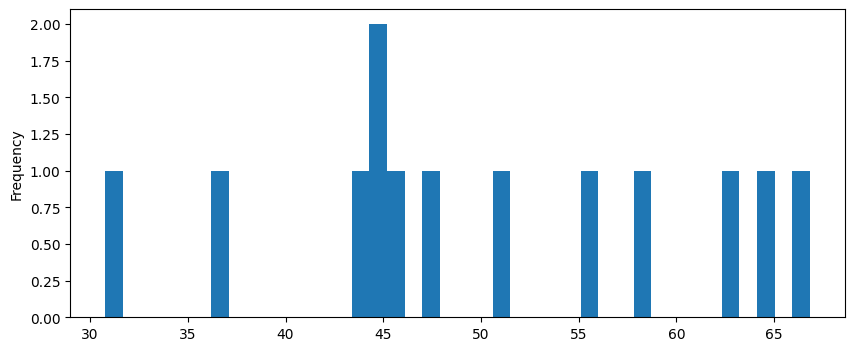

In [93]:
opuna_df['value'].plot(kind='hist', bins=40, figsize=(10, 4));

In [94]:
print('Лучшее значение:', study.best_value)
print('Среднее значение:', opuna_df['value'].mean())
print('Медианное значение:', opuna_df['value'].median())

Лучшее значение: 66.8224193548387
Среднее значение: 50.13388337468984
Медианное значение: 47.795806451612904


In [95]:
study.best_params

{'encoder_name': 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2',
 'sep': '.',
 'chunk_size': 1029,
 'chunk_overlap': 330,
 'n_top_cos': 4,
 'max_new_tokens': 561,
 'temperature': 0.2696322720540467,
 'top_p': 0.6832065754969388,
 'top_k': 90}

In [97]:
cols = ['Вопрос', 'Правильный ответ', 'Ответ', 'file_score', 'context_score', 'llm_score']
best_result[cols].head(10)

,Вопрос,Правильный ответ,Ответ,file_score,context_score,llm_score
0,Какой город является столицей Свазиленда?,Мбабане,Столицей Свазиленда является город Мбабане.,1,100,100.0
1,В каком городе пребывает Международный суд ООН?,Гаага,"Международный суд ООН пребывает в Гааге, Нидер...",1,100,100.0
2,Какая столица Вьетнама?,Ханой,Столицей Вьетнама является Ханой.,1,100,100.0
3,Чья песня Sweet dreams?,Eurythmics,"Песня ""Sweet Dreams"" принадлежит британскому п...",1,100,100.0
4,На каких языках говорят в Тайланде?,Тайский язык,В Таиланде говорят на тайском языке.,1,100,100.0
5,Когда упразднили ФМС России?,в 2016 году,ФМС России была упразднена 5 апреля 2016 года.,1,100,100.0
6,Где происходит оплодотворение яйцеклетки у жен...,В маточных трубах,Оплодотворение яйцеклетки у женщины происходит...,1,100,100.0
7,"Кто сыграл главного героя в фильме ""Форрест Га...",Хэнкс,"Том Хэнкс сыграл главного героя в фильме ""Форр...",1,98,100.0
8,Какая гора - наивысшая точка Кавказа?,Эльбрус,Наивысшей точкой Кавказа является гора Эльбрус...,1,97,100.0
9,Какая страна является местом проведения Зимних...,Корея,Зимние Олимпийские игры 2018 года проходили в ...,1,97,100.0


In [98]:
cols = ['Вопрос', 'Правильный ответ', 'Ответ', 'file_score', 'context_score', 'llm_score']
best_result[cols].tail(12)

,Вопрос,Правильный ответ,Ответ,file_score,context_score,llm_score
50,Как называется самая высокая гора Украины?,говерла,"Что-то в вашем вопросе меня смущает. Может, по...",1,92,0.0
51,В каком году обнаружили реликтовое излучение?,1948,Реликтовое излучение было открыто в 1965 году.,1,39,0.0
52,Когда началась Первая мировая?,28 июля 1914 г,Как у нейросетевой языковой модели у меня не м...,1,39,0.0
53,Что стало причиной смерти английского мореплав...,Дизентерия,"Не люблю менять тему разговора, но вот сейчас ...",1,34,0.0
54,В каком году завершилась Первая мировая?,11 ноября 1918,"Не люблю менять тему разговора, но вот сейчас ...",1,34,0.0
55,В каком году построена Эйфелева башня?,28 января 1887 г,Эйфелева башня была построена в 1889 году.,1,33,0.0
56,Когда закончились Средние века?,1500 год,"Средние века закончились в конце XVIII века, с...",1,29,0.0
57,К какой династии принадлежал Людовик 18?,Юурбонов,Людовик XVIII принадлежал к Бурбонской династии.,1,26,0.0
58,Когда написан Герой нашего времени?,1839 г,"Роман ""Герой нашего времени"" был написан Михаи...",0,22,0.0
59,Как мать Григория Перельмана?,Любовь Лейбовна Штейнгольц,"Извините, но в предоставленном вами контексте ...",0,14,0.0


In [99]:
cols = ['value', 'params_chunk_overlap', 'params_chunk_size', 'params_encoder_name',
       'params_max_new_tokens', 'params_sep', 'params_temperature',
       'params_n_top_cos', 'params_top_k', 'params_top_p']
opuna_df[cols].sort_values(by='value', ascending=False).head(9).T

,12,9,11,5,1,10,2,8,0
value,66.822419,64.518387,62.606613,58.064516,55.324839,51.215645,47.795806,45.559032,44.508548
params_chunk_overlap,330,538,316,105,521,415,469,198,110
params_chunk_size,1029,722,1039,744,1593,1052,751,1683,1653
params_encoder_name,sentence-transformers/paraphrase-multilingual-...,sentence-transformers/paraphrase-multilingual-...,sentence-transformers/paraphrase-multilingual-...,sentence-transformers/paraphrase-multilingual-...,cointegrated/rubert-tiny2,sentence-transformers/paraphrase-multilingual-...,cointegrated/rubert-tiny2,sentence-transformers/paraphrase-multilingual-...,cointegrated/rubert-tiny2
params_max_new_tokens,561,397,637,342,322,801,357,183,457
params_sep,.,.,.,,,.,\n,,\n
params_temperature,0.269632,0.091645,0.252652,0.355345,0.562592,0.969772,0.053181,0.149339,0.648665
params_n_top_cos,4,3,4,3,2,5,6,3,1
params_top_k,90,40,17,16,15,51,136,57,105
params_top_p,0.683207,0.713321,0.7247,0.905532,0.122662,0.591829,0.575313,0.269527,0.863927
